## Korean Parallel Corpora: Machine Translation

Dataset Source: https://huggingface.co/datasets/Moo/korean-parallel-corpora

#### Install Necessary Libraries

In [1]:
%pip install pip -U
%pip install torch transformers datasets evaluate tensorboard
%pip install accelerate -U
%pip install sacrebleu rouge rouge-score nltk
%pip install sentencepiece

  Obtaining dependency information for transformers from https://files.pythonhosted.org/packages/21/02/ae8e595f45b6c8edee07913892b3b41f5f5f273962ad98851dc6a564bbb9/transformers-4.31.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 1.9 MB/s eta 0:00:00
  Obtaining dependency information for datasets from https://files.pythonhosted.org/packages/66/f8/38298237d18d4b6a8ee5dfe390e97bed5adb8e01ec6f9680c0ddf3066728/datasets-2.14.4-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 5.7 MB/s eta 0:00:00
  Obtaining dependency information for huggingface-hub<1.0,>=0.14.1 from https://files.pythonhosted.org/packages/7f/c4/adcbe9a696c135578cabcbdd7331332daad4d49b7c43688bc2d36b3a47d2/huggingface_hub-0.16.4-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 13.3 MB/s eta 0:00:00
  Obtaining dependency information for safetensors>=0.3.1 from https://files.pythonhosted.org/packages/37/9b/5d880ca9f9

#### Enter HuggingFace Access Token

In [2]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


#### Import Necessary Libraries

In [3]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

from tqdm import tqdm

import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk

import transformers
from transformers import DataCollatorForSeq2Seq, AutoModelForSeq2SeqLM, set_seed
from transformers import AutoTokenizer, Seq2SeqTrainingArguments, Seq2SeqTrainer

import datasets
from datasets import Dataset, DatasetDict, load_dataset

import evaluate

!git lfs install

Git LFS initialized.


#### Versions of Software & Libraries Used

In [4]:
library_len = 14
version_len = 12

print(f"+{'-' * (library_len + version_len + 5)}+")
print("|",
      "Library".rjust(library_len),
      "|",
      "Version".ljust(version_len),
      "|")

print(f"|{'*' * (library_len + version_len + 5)}|")

print("|",
      "Python".rjust(library_len),
      "|",
      sys.version[0:6].ljust(version_len),
      "|")

print("|",
      "NumPy".rjust(library_len),
      "|",
      np.__version__.ljust(version_len),
      "|")

print("|",
      "Pandas".rjust(library_len),
      "|",
      pd.__version__.ljust(version_len),
      "|")

print("|",
      "Torch".rjust(library_len),
      "|",
      torch.__version__.ljust(version_len),
      "|")

print("|",
      "Datasets".rjust(library_len),
      "|",
      datasets.__version__.ljust(version_len),
      "|")

print("|",
      "Transformer".rjust(library_len),
      "|",
      transformers.__version__.ljust(version_len),
      "|")

print(f"+{'-' * (library_len + version_len + 5)}+")

+-------------------------------+
|        Library | Version      |
|*******************************|
|         Python | 3.10.1       |
|          NumPy | 1.23.5       |
|         Pandas | 1.5.3        |
|          Torch | 2.0.1+cu118  |
|       Datasets | 2.14.4       |
|    Transformer | 4.31.0       |
+-------------------------------+


#### Ingest & Start Preprocessing Data

In [5]:
data = load_dataset("Moo/korean-parallel-corpora")

data

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['ko', 'en'],
        num_rows: 96215
    })
    validation: Dataset({
        features: ['ko', 'en'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['ko', 'en'],
        num_rows: 2000
    })
})

#### Convert Dataset to Pandas DataFrame

In [6]:
data.set_format(type="pandas")

df = data['train'][:]

df = df.drop_duplicates()

df = df.reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80949 entries, 0 to 80948
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ko      80949 non-null  object
 1   en      80949 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


#### Visual: Length of English Entries

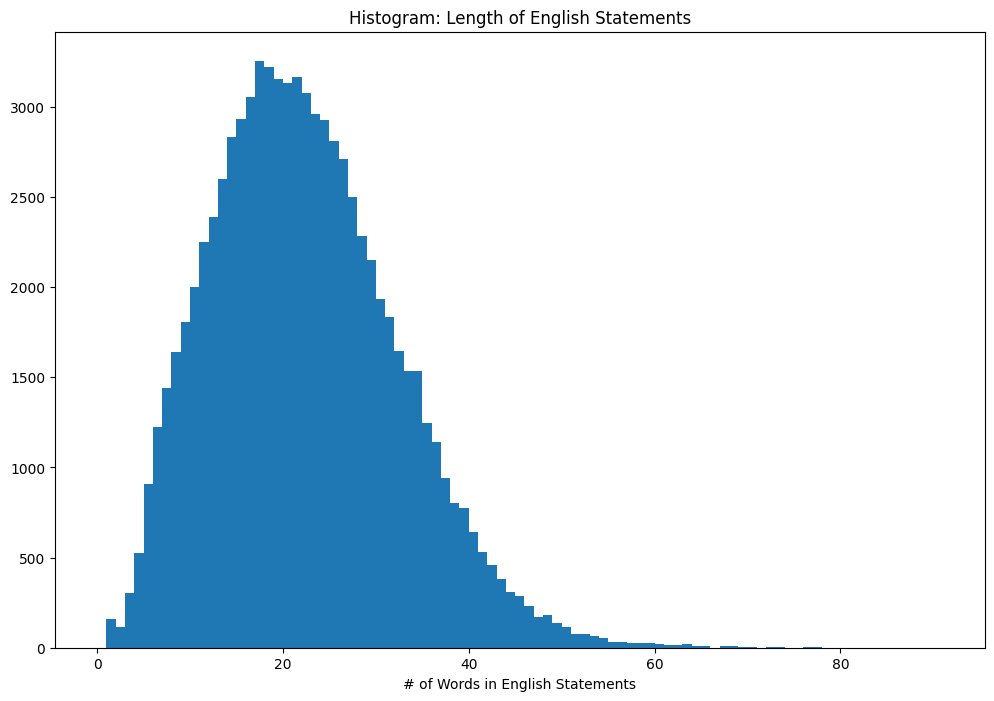

The Maximum length of English text is 90 words.


In [7]:
df['english_length'] = df['en'].str.split().str.len()

max_english_count = max(df['english_length'])

n_bin = max_english_count + 1

df.hist('english_length',
        grid=False,
        figsize=(12,8),
        range=(0,n_bin),
        bins=n_bin)
plt.title('Histogram: Length of English Statements')
plt.xlabel('# of Words in English Statements')
plt.show()

print(f"The Maximum length of English text is {max_english_count} words.")

#### Visual: Length of Korean Entries

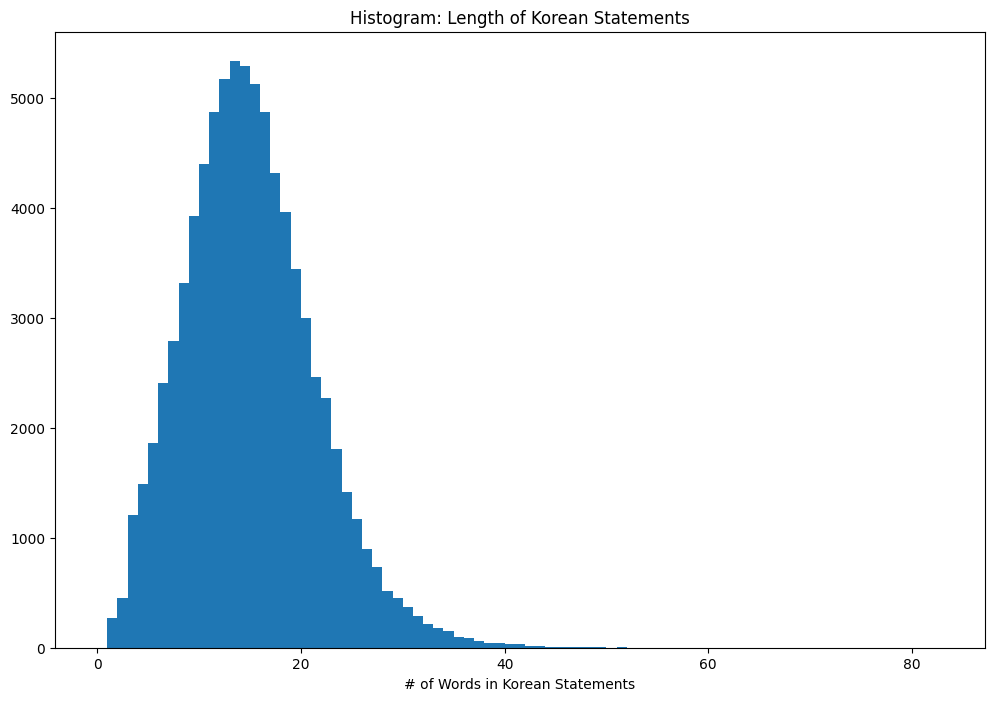

The Maximum length of Korean text is 82 words.


In [8]:
df['korean_length'] = df['ko'].str.split().str.len()

max_korean_count = max(df['korean_length'])

n_bin = max_korean_count + 1

df.hist('korean_length',
        grid=False,
        range=(0,n_bin),
        figsize=(12,8),
        bins=n_bin)
plt.title('Histogram: Length of Korean Statements')
plt.xlabel('# of Words in Korean Statements')
plt.show()

print(f"The Maximum length of Korean text is {max_korean_count} words.")

#### Trim Dataset Size & Drop Unnecessary Features

In [9]:
most_input_words_en = 55
most_input_words_ko = 41
least_input_words = 2

# make sure that English text is less than 55 & more than 2 words
df = df[df['korean_length'] < most_input_words_ko]
df = df[df['korean_length'] > least_input_words]

# make sure that Korean text is less than 41 & more than 2 words
df = df[df['english_length'] < most_input_words_en]
df = df[df['english_length'] > least_input_words]

# reset the index
df = df.reset_index(drop=True)

# Remove columns that are no longer necessary
df = df.drop(columns=['korean_length',
                      'english_length'
                      ]
             )

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79733 entries, 0 to 79732
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ko      79733 non-null  object
 1   en      79733 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


#### Final Preprocessing

In [10]:
all_data = df.to_dict(orient='records')
df = pd.Series(all_data)
df = pd.DataFrame(df)
df.rename(columns={ 0 : 'translation'}, inplace=True)
df.head()

,translation
0,"{'ko': '개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""',..."
1,{'ko': '모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패...
2,"{'ko': '그러나 이것은 또한 책상도 필요로 하지 않는다.', 'en': 'Li..."
3,"{'ko': '79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그..."
4,{'ko': '정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이...


#### Convert to Dataset Format & Split into Train/Test/Eval Datasets

In [12]:
dataset = Dataset.from_pandas(df)

train_testEval = dataset.train_test_split(train_size=0.65)
test_eval = train_testEval['test'].train_test_split(train_size=0.50)

ds = DatasetDict({
    'train' : train_testEval['train'],
    'test' : test_eval['train'],
    'eval' : test_eval['test'],
})

print("Training Dataset Shape:", ds['train'].shape)
print("Testing Dataset Shape:", ds['test'].shape)
print("Evaluation Dataset Shape:", ds['eval'].shape)

print(f"\nTraining Dataset Example:\n{ds['train'][25]}")

Training Dataset Shape: (51826, 1)
Testing Dataset Shape: (13953, 1)
Evaluation Dataset Shape: (13954, 1)

Training Dataset Example:
{'translation': {'en': "Under her tenure, the company's revenue grew from $285 million to more than $1.5 billion.", 'ko': '그가 역임하는 동안 오도데스크은 2억8500억원에서 15억달러 이상 수익을 올렸다.'}}


#### Basic Values/Constants

In [13]:
set_seed = 42
NUM_OF_EPOCHS = 6

BATCH_SIZE = 32
LEARNING_RATE = 2e-5

SOURCE_LANGUAGE = "ko"
TARGET_LANGUAGE = "en"

MODEL_CKPT = "Helsinki-NLP/opus-mt-ko-en"

MODEL_NAME = f"{MODEL_CKPT.split(f'/')[-1]}-Korean_Parallel_Corpora"

REPORTS_TO = "tensorboard"
STRATEGY = "epoch"

#### Create Tokenizer

In [14]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


#### Create Preprocessing Function

In [15]:
def tokenizing_function(examples):
    inputs = [ex[SOURCE_LANGUAGE] for ex in examples['translation']]
    targets = [ex[TARGET_LANGUAGE] for ex in examples['translation']]
    model_inputs = tokenizer(inputs,
                             text_target=targets,
                             truncation=True)
    return model_inputs

#### Apply Preprocessing Function to Dataset

In [16]:
encoded_ds = ds.map(tokenizing_function,
                    batched=True)

print(encoded_ds['train'].shape)
print(encoded_ds['test'].shape)
print(encoded_ds['eval'].shape)

Map:   0%|          | 0/51826 [00:00<?, ? examples/s]

Map:   0%|          | 0/13953 [00:00<?, ? examples/s]

Map:   0%|          | 0/13954 [00:00<?, ? examples/s]

(51826, 4)
(13953, 4)
(13954, 4)


#### Instantiate Model

In [17]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_CKPT)

#### Instantiate Data Collator

In [18]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer,
                                       model=MODEL_CKPT)

#### Create Function to Compute Metrics

In [19]:
bleu_metric = evaluate.load("sacrebleu")
rouge_metric = evaluate.load("rouge")

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds

    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer.batch_decode(preds,
                                           skip_special_tokens=True)

    labels = np.where(labels != -100,
                      labels,
                      tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels,
                                            skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds,
                                                     decoded_labels)

    bleu_results = bleu_metric.compute(predictions=decoded_preds,
                                       references=decoded_labels)
    rouge_results = rouge_metric.compute(predictions=decoded_preds,
                                         references=decoded_labels)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id)
                       for pred in preds]

    return {"bleu" : bleu_results["score"],
            "rouge" : rouge_results,
            "Prediction Lengths": prediction_lens}

#### Instantiate Training Arguments

In [20]:
args = Seq2SeqTrainingArguments(output_dir=MODEL_NAME,
                                auto_find_batch_size=True,
                                gradient_accumulation_steps=4,
                                eval_accumulation_steps=4,
                                evaluation_strategy="no",
                                save_strategy=STRATEGY,
                                logging_strategy="steps",
                                logging_steps=250,
                                logging_first_step=True,
                                learning_rate=LEARNING_RATE,
                                report_to=REPORTS_TO,
                                weight_decay=0.01,
                                disable_tqdm=False,
                                num_train_epochs=NUM_OF_EPOCHS,
                                predict_with_generate=True,
                                fp16=True,
                                group_by_length=True,
                                hub_private_repo=True,
                                push_to_hub=True
                                )

#### Instantiate Trainer

In [21]:
trainer = Seq2SeqTrainer(model=model,
                         args=args,
                         train_dataset=encoded_ds['train'],
                         eval_dataset=encoded_ds['eval'],
                         tokenizer=tokenizer,
                         data_collator=data_collator,
                         compute_metrics=compute_metrics)

Cloning https://huggingface.co/DunnBC22/opus-mt-ko-en-Korean_Parallel_Corpora into local empty directory.


#### Train Model

In [23]:
train_results = trainer.train()

Step,Training Loss
1,3.626300
250,3.266100
500,3.187800
750,3.111600
1000,3.065200
1250,3.050700
1500,3.001200
1750,2.921700
2000,2.817900
2250,2.810300


Adding files tracked by Git LFS: ['source.spm', 'target.spm']. This may take a bit of time if the files are large.


#### Push Model to HuggingFace Hub (My Profile!)

In [24]:
trainer.push_to_hub()

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/296M [00:00<?, ?B/s]

Upload file runs/Aug15_19-29-28_7b940da3f0d6/events.out.tfevents.1692127787.7b940da3f0d6.1267.0:   0%|        …

To https://huggingface.co/DunnBC22/opus-mt-ko-en-Korean_Parallel_Corpora
   61e4661..4dda213  main -> main

   61e4661..4dda213  main -> main

To https://huggingface.co/DunnBC22/opus-mt-ko-en-Korean_Parallel_Corpora
   4dda213..98651f5  main -> main

   4dda213..98651f5  main -> main



'https://huggingface.co/DunnBC22/opus-mt-ko-en-Korean_Parallel_Corpora/commit/4dda213e33bfdad07b32f3c7f3a0620618e8844b'

#### Save & Log Model

In [25]:
trainer.save_model()
trainer.save_state()

#### Evaluate Model

In [26]:
metrics = trainer.evaluate()

Trainer is attempting to log a value of "{'rouge1': 0.43909974211672487, 'rouge2': 0.20218611803466308, 'rougeL': 0.36711995473573833, 'rougeLsum': 0.36713843158213144}" of type <class 'dict'> for key "eval/rouge" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[13, 30, 34, 32, 24, 16, 53, 38, 17, 10, 35, 20, 33, 21, 26, 21, 13, 14, 36, 34, 18, 20, 23, 19, 22, 35, 27, 46, 33, 61, 22, 29, 36, 32, 47, 17, 23, 43, 28, 23, 23, 7, 22, 48, 31, 40, 20, 18, 29, 34, 8, 29, 19, 28, 50, 30, 27, 20, 15, 54, 33, 19, 26, 26, 34, 38, 46, 16, 33, 29, 27, 33, 29, 26, 23, 14, 135, 14, 15, 9, 30, 31, 22, 10, 19, 17, 15, 36, 21, 34, 27, 38, 24, 36, 23, 29, 23, 37, 41, 16, 35, 40, 24, 17, 41, 26, 97, 18, 7, 46, 42, 18, 13, 35, 24, 35, 21, 8, 31, 12, 51, 58, 18, 40, 43, 18, 19, 34, 17, 18, 27, 22, 24, 18, 38, 46, 18, 15, 33, 49, 31, 32, 16, 43, 17, 24, 23, 15, 15, 36, 31, 26, 47, 42, 24, 51, 31, 36, 23, 31,

#### Print Metric Values

In [28]:
print(metrics)

{'eval_loss': 2.662041664123535, 'eval_bleu': 14.3394821840289, 'eval_rouge': {'rouge1': 0.43909974211672487, 'rouge2': 0.20218611803466308, 'rougeL': 0.36711995473573833, 'rougeLsum': 0.36713843158213144}, 'eval_Prediction Lengths': [13, 30, 34, 32, 24, 16, 53, 38, 17, 10, 35, 20, 33, 21, 26, 21, 13, 14, 36, 34, 18, 20, 23, 19, 22, 35, 27, 46, 33, 61, 22, 29, 36, 32, 47, 17, 23, 43, 28, 23, 23, 7, 22, 48, 31, 40, 20, 18, 29, 34, 8, 29, 19, 28, 50, 30, 27, 20, 15, 54, 33, 19, 26, 26, 34, 38, 46, 16, 33, 29, 27, 33, 29, 26, 23, 14, 135, 14, 15, 9, 30, 31, 22, 10, 19, 17, 15, 36, 21, 34, 27, 38, 24, 36, 23, 29, 23, 37, 41, 16, 35, 40, 24, 17, 41, 26, 97, 18, 7, 46, 42, 18, 13, 35, 24, 35, 21, 8, 31, 12, 51, 58, 18, 40, 43, 18, 19, 34, 17, 18, 27, 22, 24, 18, 38, 46, 18, 15, 33, 49, 31, 32, 16, 43, 17, 24, 23, 15, 15, 36, 31, 26, 47, 42, 24, 51, 31, 36, 23, 31, 26, 35, 29, 16, 10, 14, 9, 29, 15, 31, 18, 35, 33, 32, 22, 32, 26, 33, 47, 14, 21, 19, 13, 26, 13, 48, 21, 13, 26, 32, 19, 40, 40

### Notes & Other Takeaways From This Project
****
- These are not the results I was expecting, but I will learn from this project and incorporate that wisdom in projects going forward.

****

#### Citations

- Model Checkpoint
    > https://huggingface.co/Helsinki-NLP/opus-mt-ko-en

- Metrics
    - Bleu
        > @INPROCEEDINGS{Papineni02bleu:a, author = {Kishore Papineni and Salim Roukos and Todd Ward and Wei-jing Zhu}, title = {BLEU: a Method for Automatic Evaluation of Machine Translation}, booktitle = {}, year = {2002}, pages = {311--318}}
        
        > @inproceedings{lin-och-2004-orange, title = "{ORANGE}: a Method for Evaluating Automatic Evaluation Metrics for Machine Translation", author = "Lin, Chin-Yew and Och, Franz Josef", booktitle = "{COLING} 2004: Proceedings of the 20th International Conference on Computational Linguistics", month = "aug 23{--}aug 27", year = "2004", address = "Geneva, Switzerland", publisher = "COLING", url = "https://www.aclweb.org/anthology/C04-1072", pages = "501--507",}
    
    - Rouge
        > @inproceedings{lin-2004-rouge, title = '{ROUGE}: A Package for Automatic Evaluation of Summaries', author = 'Lin, Chin-Yew', booktitle = 'Text Summarization Branches Out', month = jul, year = '2004', address = 'Barcelona, Spain', publisher = 'Association for Computational Linguistics', url = 'https://www.aclweb.org/anthology/W04-1013', pages = '74--81',}